# Импорт библиотек, предобработка данных, токенизация и создание обучающих последовательностей, построение и компиляция модели

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.models import load_model


from google.colab import drive
drive.mount('/content/drive')


data = pd.read_csv('/content/drive/MyDrive/movies_subtitles.csv')


data['text'] = data['text'].fillna('')


data = data.head(10000)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'].values.tolist())
total_words = len(tokenizer.word_index) + 1


input_sequences = []
for line in data['text'].values.tolist():
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


max_sequence_len = max([len(x) for x in input_sequences])


input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


X, y = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)


model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Обучение модели

In [16]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=30, verbose=1)

Epoch 1/30
1788/1788 [==============================] - 29s 14ms/step - loss: 6.6005 - accuracy: 0.0510
Epoch 2/30
1788/1788 [==============================] - 17s 10ms/step - loss: 5.8786 - accuracy: 0.0892
Epoch 3/30
1788/1788 [==============================] - 19s 10ms/step - loss: 5.4197 - accuracy: 0.1211
Epoch 4/30
1788/1788 [==============================] - 18s 10ms/step - loss: 5.0431 - accuracy: 0.1421
Epoch 5/30
1788/1788 [==============================] - 19s 10ms/step - loss: 4.6981 - accuracy: 0.1631
Epoch 6/30
1788/1788 [==============================] - 18s 10ms/step - loss: 4.3712 - accuracy: 0.1888
Epoch 7/30
1788/1788 [==============================] - 17s 10ms/step - loss: 4.0592 - accuracy: 0.2213
Epoch 8/30
1788/1788 [==============================] - 17s 10ms/step - loss: 3.7640 - accuracy: 0.2588
Epoch 9/30
1788/1788 [==============================] - 18s 10ms/step - loss: 3.4920 - accuracy: 0.2979
Epoch 10/30
1788/1788 [==============================] - 18s 10m

In [17]:
# Сохранение модели
model.save('/content/drive/MyDrive/trained_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Загрузка модели
model = load_model('/content/drive/MyDrive/trained_model.h5')

# Графики метрик

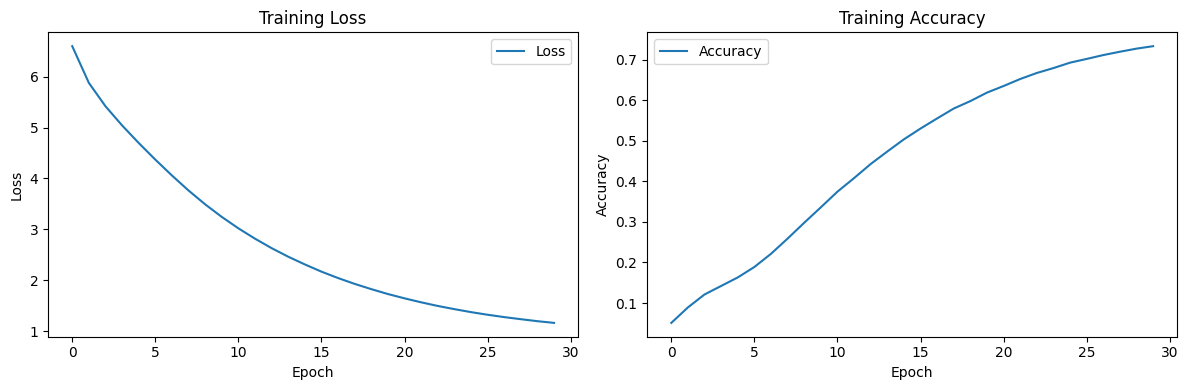

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Пример использования

In [19]:
# Генерация текста
def generate_text(seed_text, next_words, max_sequence_len, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)

        # Применение температуры
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions + 1e-7) / temperature
        exp_predictions = np.exp(predictions)
        predictions = exp_predictions / np.sum(exp_predictions)


        predicted = np.random.choice(range(total_words), p=predictions.ravel())

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Пример генерации текста
generated_text = generate_text("What if", 10, max_sequence_len, temperature=1.0)
print(generated_text)

What if we show us the lie detector rules might be an


Процесс обучения модели на текстовых данных показал хорошие результаты: функция потерь постепенно уменьшалась, а точность увеличивалась, что свидетельствует об улучшении качества модели.
Однако в процессе работы я столкнулся с ограниченными техническими возможностями своего компьютера. ПК имеет ограниченную оперативную память и вычислительные ресурсы, что замедляло процесс обучения, ограничивало возможность использования больших объемов данных и конечно влияло на точность.
Также я использовал такой гиперпараметр, как температура, которая влияет на процесс генерации текста: она позволяет регулировать степень случайности при создании текста. При высокой температуре модель генерирует более разнообразные и менее предсказуемые ответы, а при низкой температуре ответы становятся более однообразными и предсказуемыми. Это помогает сделать так, чтобы при каждом запуске модель генерировала разные результаты, добавляя элемент разнообразия.